The task is two-fold: firstly, we must compute trending market segments over a given time period and, secondly, we must compute a market index.

One may skip directly to the 'The trending functions:' section for the results.

# Trending market segments

In this section, we shall end up with __two__ functions which give the top trending market segments for a specified time period. Beforehand, we shall define some useful functions.

To perform this task, it is useful to ask the following questions: 

* How to determine what a market segment is?
* What does it mean for a market segment to trend?
* How to determine the popularity of a market segment?

Before answering these questions, we first load the JSON file (firstly changing to the appropriate directory, modify as appropriate):

In [2]:
cd C:\Users\Michael\Desktop

C:\Users\Michael\Desktop


In [3]:
import json

#load the json file
with open('projects.json') as file:
    data = json.load(file)
    
#print type and length of the json file
print((type(data), len(data)))

(<class 'list'>, 130756)


We note that the data is of the form:

In [4]:
#{
#	"url": "Link to the campaign on the platform website",
#	"platform_name": "Name of Platform",
#	"status": "Campaign status",
#	"concepts": {
#	   "title": ["The concepts within the title"],
#	   "subtitle": ["The concepts within the sub title"],
#	   "description": ["The concepts within the description"],
#	   "category": ["The concepts within the category"]
#	 },
#	 "start_time": "Project start date.",
#	 "end_time": "Project end date. ",
#	 "goal_fx": {
#		"GBP": "Amount of money campaigning for, in GBP"
#	 },
#	 "raised_fx": {
#		"GBP": "Amount of money currently raised, in GBP"
#	 }
#}

#Where concepts are defined as a list of the following structures:

#{
#   "start": "The position of the last character of what the concept represents in the corresponding text field (starts at 0)",
#   "end": "The position of the last character of what the concept represents in the corresponding text field (starts at 0)",
#   "concept": "The actual concept"
#}

In particular, we have key words from the title of the campaign, the subtitles, the description and the category of the campaign.

We now return to the first question in the earlier list.

## How to determine what a market segment is?

__Assumption:__ All of the information about the market segment of a given campaign is contained in the 'category' of the campaign.

We take this assumption such that we do not end up with overly specific market segments. We note that our code is easily modified to include the other 'concepts'.

__Limitation of assumption:__ There is a risk that, in taking this assumption, we miss the finer details of market segments. 

__Assumption:__ For the case in which there are multiple concepts within 'category', we take the market segment of the campaign to be the union of the two concepts, rather than its intersection.

This assumption is also taken such that we do not end up with overly specific market segments.

__Possible extension:__

Finally, we should also take into account synonyms or related concepts. For example, one campaign may have belong to the 'movie' market segment, while another may belong to the 'film' market segment. Most likely, we would want to consider these as the same market segment. To achieve this grouping of equivalent/related market segments, one may consider an unsupervised learning clustering algorithm, such as non-negative matrix factorization. A first attempt at this is included in the appendix, though the results were not great and so this should be viewed as illustrating a possible approach, rather than providing results.

## What does it mean for a market segment to trend?

__Assumption:__ There are three ways to determine whether a market segment is trending:

* competitive benchmarking,
* historical benchmarking,
* a combination of the above two methods.

_Competitive benchmarking_ is the comparison of the popularity of a market segment with other market segments, i.e. a market segment is trending if the market segment is more popular than other market segments.

_Historical benchmarking_ is the comparison of the popularity of a market segment with its historical popularity. Segments are ranked according to their % change in popularity on the previous time period.

We shall adopt a hybrid approach of the two as, individually, each approach has its failings.

__$\chi^2$:__ One such hybrid approach is to use the $\chi^2$ value. This approach goes as follows:

* Suppose a market segment, $i$, has observed occurences $O_i$ in a given time period.
* Furthermore suppose that this market segment has an expected value $E_i$, as computed over the preceding $N$ time periods of equal length to that being considered.
* Then the $\chi^2$ value of $i$, denoted by $\chi^2_i$, is given by:

$\chi^2_i = (O_i - E_i)^2 \left(\frac{1}{E_i + m} + \frac{1}{N}\right)$

where $m$ is a 'smoothing parameter', whose purpose is to ensure that segments with low expected values do not overly dominate the top trending segments.
* We rank the market segments by their $\chi^2$ values.

__z-score:__ Another such hybrid approach is to use a z-score based approach. This approach goes as follows:

* Suppose a market segment, $i$, has observed occurences $O_i$ in a given time period.
* Furthermore suppose that this market segment has an expected value $E_i$, as computed over the preceding time period of equal length to that being considered.
* We compute the 'growth', $g_i$, of $i$ as:

$g_i = 100(O_i - E_i)/(E_i + m)$

where $m$ is a smoothing parameter, as in the $\chi^2$ case.
* We divide the data according to the values $E_i$. We denote the resulting division to which $i$ belongs as $J$. 
* Then the _growth_ z-score of the segment $i$ within $J$, denoted by $z_i^J$, is given by:

$z_{i}^{J} = (g_i - g^J_{mean}) / g^J_{std}$

where $g^J_{mean}$ and $g^J_{std}$ are the mean and standard deviation of the growth of the segments within the division $J$, respectively.

* We perform a number of divisions, computing the growth z-scores of each market segment within each of division and average over these growth z-scores.
* We rank the market segments by their average growth z-score value.

__Comparing the two approaches:__

__$\chi^2$:__ 
* Potentially more computationally intensive, if we wish to achieve large $N$.
* Distinguishes noise from true trending by studying historical data for the segment.
* Attempts to adjust for the possibility of occurences with very low previous values appearing artificially high in the rankings by squaring $(O_i - E_i)$ in the numerator.
* The results will depend on the choice of smoothing parameter, which is not ideal.

__z-score:__
* Less computationally intensive - we only consider the present and immediately preceding time periods.
* Distinguishes noise from true trending by studying market segments with similar numbers of previous occurences.
* Attempts to adjust for the possibility of occurences with very low previous values appearing artificially high in the rankings by dividing the data multiple times and in different ways.
* The results will depend on the choice of smoothing parameter as well as the choice of dividing the data, which is not ideal.

__In summary__, if we are not too worried about the speed of the process and we have sufficient data to achieve large $N$, then we probably should use the $\chi^2$ approach. However, if speed is a priority or we have insufficient data to achieve large $N$, 
then we should probably consider the z-score approach.

In [5]:
from datetime import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#import timer
from timeit import default_timer as timer

We now define a dictionary, 'count_dict', which has concepts as keys, and the respective number of times these concepts occur in the campaigns' 'category' as the respective values (this excludes multiple occurences within a single campaign).

In [6]:
def count_unique(data, header_list, start_date, end_date):
    
    """function which takes the data, a header list, as well as a start date and an end date 
    (non-inclusive), in the form 'yyyy-mm-dd' (of type string), with the start date before the 
    end date. outputs a dictionary with keys which are the 'category' entries in 'data' for the 
    given time period and with values which are the number of campaigns for which the key occurs 
    in campaigns."""
        
    try:
    
        #we check that start_date and end_date are of the correct form and that
        #start_date is before end_date
        datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')
        if start_date > end_date:
            print('Error: start_date must be before end_date')
        
        else:
            N = len(data)
            count_dict = {}

            for n in range(N):
            
                unique_list = []
                #restrict to the desired time period, i.e. the start date of the campaign
                #is before the end of the time period and the end date is after the start date
                if (data[n]['start_time'] < end_date) and (data[n]['end_time'] >= start_date):
                    #not all campaigns contain the key 'concepts'
                    #so we filter these
                    if 'concepts' in data[n].keys():
                        #loop over the headers in header_list
                        for header in header_list:
                            #check that this appears in the subdictionary keys
                            if header in data[n]['concepts'].keys():
                                #loop over the items in the dictionary
                                for item in data[n]['concepts'][header]:
                                    #either add the concept to the dictionary as
                                    #a key if it has not appeared before, or add
                                    #to the keys count, i.e. to its value
                                    if item['concept'] not in unique_list:
                                        unique_list.append(item['concept'])
                        for unique_item in unique_list:
                            if unique_item not in count_dict.keys():
                                count_dict[unique_item] = 1
                            else:
                                count_dict[unique_item] += 1
                                
            return count_dict
    
    #print an error message if there is a type error
    except TypeError:
        
        print('Error: start_date and end_date must be strings of the form yyyy-mm-dd')

We time this function for the full dataset, for the 'category' header, with the range of a month and time it.

In [7]:
header_list = ['category']
start_d, end_d = '2016-01-01', '2016-02-01'

start = timer()
count_unique(data, header_list, start_d, end_d)
print(timer() - start)

0.08373347799631989


We now print the start and the end points of our data set. We also compare the number of campaigns with these respective start or finish dates with the median number of campaigns for any start or end date within the data (we drop campaigns without a 'concepts' key, which contains all the information about topics).

In [8]:
#generate a list of all the start and end dates of campaigns
start_list, end_list = [], []
for n in range(len(data)):
    if 'concepts' in data[n].keys():
        start_list.append(data[n]['start_time']), end_list.append(data[n]['end_time'])

start_array, end_array = pd.Series(start_list), pd.Series(end_list)
data_start, data_end = min(start_array), max(end_array)

print('The dataset start and finish dates are: %s, %s.' % (data_start, data_end))

print('The number of campaigns starting on the first day of our dataset are %s, '
      'while the median number of campaigns starting on a given start date within our dataset is %s.'
      % (len(start_array[start_array == min(start_array)]), int(start_array.value_counts().median())))

print('The number of campaigns ending on the last day of our dataset are %s, '
     'while the median number of campaigns ending on a given end date within our dataset is %s.'
     % (len(end_array[end_array == max(end_array)]), int(end_array.value_counts().median())))

The dataset start and finish dates are: 2015-01-01, 2016-12-31.
The number of campaigns starting on the first day of our dataset are 77, while the median number of campaigns starting on a given start date within our dataset is 103.
The number of campaigns ending on the last day of our dataset are 6, while the median number of campaigns ending on a given end date within our dataset is 122.


There are large differences between the number of campaigns starting and finishing on the start and end dates of the datasets and the median. We will keep this in mind later.

We now define a function, chi_squared, which computes the $\chi^2$ values for each market segment in a given time period.

In [9]:
def chi_squared(data, header_list, start_date, end_date, smooth_param):
    
    """function which takes the dataset, a header list, two dates and a smoothing parameter 
    as an input. returns a dataframe with market segments as indices. the columns are the 
    count of each market segment in the time period and its chi^2 value"""
    
    #define series of the start and end dates of each entry in the dataset
    start_list, end_list = [], []
    for n in range(len(data)):
        start_list.append(data[n]['start_time']), end_list.append(data[n]['end_time'])
    start_series, end_series = pd.Series(start_list), pd.Series(end_list)
    
    #store the min and max of the dates
    data_start, data_end = min(start_array), max(end_array)
    
    #convert start_date and end_date to datetime objects
    start_dtime = datetime.strptime(start_date, '%Y-%m-%d')
    end_dtime = datetime.strptime(end_date, '%Y-%m-%d')
    data_start_dtime = datetime.strptime(data_start, '%Y-%m-%d')
    data_end_dtime = datetime.strptime(data_end, '%Y-%m-%d')
    
    #define the length of the time period being considered
    time_diff = end_dtime - start_dtime
    
    #define and print the maximum number possible for N,
    #i.e. the number of historical time periods
    max_steps =  int((start_dtime - data_start_dtime) / time_diff)
    print("N: %d" % (max_steps))
    
    #stop if there is no historical data available
    if max_steps <= 0:
        print('No historical data available, with which to evaluate trending.')
        return pd.DataFrame([])
    
    #define a list with all the start and end dates of the preceding N periods
    date_list = []
    for n in range(max_steps):
        date_list.append((datetime.strftime(start_dtime - (n * time_diff), '%Y-%m-%d'),
                         datetime.strftime(end_dtime - (n * time_diff), '%Y-%m-%d')))
    
    #define a dictionary with keys that are the entries of date_list
    #and with values which are dataframes defined using the dictionary
    #output of count_unique for each period
    count_dict = {k:None for k in date_list}
    for n in range(len(date_list)):
        temp_dict = count_unique(data, header_list, date_list[n][0], date_list[n][1])
        temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
        count_dict[date_list[n]] = temp_df
    
    #label the columns by the time period
    keys = [k for k in count_dict.keys()]
    for k in keys:
        count_dict[k].columns = [k]
    
    #concatenate all of the dataframes
    temp_list = []
    for k in count_dict.values():
        temp_list.append(k)
    hist_df = pd.concat(temp_list, axis=1).fillna(0)
    #drop market segments without a count in the current period
    hist_df = hist_df[hist_df.iloc[:, 0] != 0]
    
    #define the expected column
    hist_df['expected'] = hist_df.iloc[:, 1:].apply(np.mean, axis=1)
    #consider only segments whose current count is larger than the expected value
    hist_df = hist_df[hist_df.iloc[:, 0] > hist_df.expected]
    
    #compute the chi^2 values (with smoothing parameter)
    hist_df['chi_sq'] = ((hist_df.iloc[:, 0] - hist_df.expected) ** 2) * ((1 / (hist_df.expected + smooth_param)) + 
                                                                           (1  / (max_steps - 1)))
    
    #return the dataframe (keeping just current count, expected and chi_sq columns), 
    #sorted according to the chi_sq value
    hist_df = hist_df.iloc[:, [0, -2, -1]].sort_values('chi_sq', ascending=False)

    hist_df['rank'] = np.arange(1, hist_df.shape[0] + 1)
    
    hist_df.columns = ['count', 'expected', 'chi_sq', 'rank']
    hist_df['count'] = hist_df['count'].astype(int)
    
    return hist_df

In [10]:
header_list = ['category', 'title']
start_d, end_d = '2016-01-01', '2016-02-01'
smooth_param = 1

start = timer()
df = chi_squared(data, header_list, start_d, end_d, smooth_param)
end = timer()
print(end - start)

df.head()

N: 11
2.7097913871763106


,count,expected,chi_sq,rank
glory,4,0.8,6.712889,1
translations,6,2.3,5.517485,2
force,3,0.5,4.791667,3
connect,3,0.5,4.791667,4
space gangstars,2,0.0,4.400000,5


Presently, we define a function, growth, which takes a dataset (of the form described earlier) and two dates as input. It outputs a dataframe whose indices are the concepts. The columns of the dataframe are the popularity of the concepts within the given time period, the absolute popularity of the concepts in the immediately preceding period of the same length and the % change in absolute popularity of the concepts between the two periods.

In [11]:
def growth(data, header_list, start_date, end_date, smooth_param):
    
    """function which takes the data, as well as a start date and an end date (non-inclusive), 
    in the form 'yyyy-mm-dd', with the start date before the end date. outputs a dataframe
    with the trending market segments, as described earlier."""
   
    #convert start_date and end_date to datetime objects
    start_dtime = datetime.strptime(start_date, '%Y-%m-%d')
    end_dtime = datetime.strptime(end_date, '%Y-%m-%d')
    #compute the length of the time interval to consider
    time_diff = end_dtime - start_dtime
    #define the previous time period to consider, of the same length as the current one
    start_dtime_prev = start_dtime - time_diff
    #convert to strings
    start_date_prev, end_date_prev = datetime.strftime(start_dtime_prev, '%Y-%m-%d'), start_date

    #print a warning message if any start or end dates fall outside of the dataset
    if start_date_prev < data_start or end_date > data_end:
        print('Some of the time period specified, and/or the preceding period, falls '
              + 'outside the limits of the dataset: ' + str(data_start) + ', ' + str(data_end))
        
        return pd.DataFrame([])
    
    #compute the absolute popularity of segments for both time periods
    data_list = [count_unique(data, header_list, start_date, end_date), 
                 count_unique(data, header_list, start_date_prev, end_date_prev)]
        
    df_list, name_list = [], ['current_', 'previous_']
    for n in range(len(data_list)):
        d = data_list[n] #convert to a dictionary
        df = pd.DataFrame.from_dict(d, orient='index') #to dataframe
        if len(df.columns) > 0:
            df.columns = [name_list[n] + 'count'] #name the columns
            df_list.append(df)
        else:
            df_list.append(pd.DataFrame(columns=[name_list[n] + 'count']))
            
    #concatenate the dataframes
    combined_df = pd.concat(df_list, axis=1).reindex(df_list[0].index)
    combined_df = combined_df.loc[combined_df.current_count.dropna().index]
    combined_df.current_count = combined_df.current_count.astype(int)
    combined_df.previous_count = combined_df.previous_count.astype(object)
    
    combined_df['growth'] = 100 * (combined_df.current_count - 
                                     combined_df.previous_count) / (combined_df.previous_count + smooth_param)
    
    #order according to  
    combined_df = combined_df.sort_values('growth', ascending=False)
    
    #add a rank column
    #combined_df['rank'] = np.arange(1, combined_df.shape[0] + 1)
        
    return combined_df

In [12]:
header_list = ['category', 'title']
start_d, end_d = '2016-01-01', '2016-02-01'
smooth_param = 1

start = timer()
df = growth(data, header_list, start_d, end_d, smooth_param)
end = timer()
print(end - start)

df.head()

0.19657402859537632


,current_count,previous_count,growth
translations,6,1,250
worlds,4,1,150
hope,4,1,150
food trucks,11,4,140
gaming hardware,6,2,133.333


We now define a function which divides the data into diffent percentile intervals of the previous count. It then computes the zscores for the data in each percentile interval, before averaging over these z-scores for each concept.

The purpose of this is illustrated above. We can see that all of the first 5 elements, ranked by '% change', have very low values of 'previous_count'. The weighting means that a concept will be ranked highly only if its % change is high relative to its peers.

In [13]:
def zscore(data, header_list, start_date, end_date, smooth_param):
    
    #define a growth data frame, using growth
    df = growth(data, header_list, start_date, end_date, smooth_param)
    
    if df.shape == (0, 0):
        return pd.DataFrame([])
    
    #fill the null values with 0s
    if df.shape[0] > 0:
        df.previous_count = df.previous_count.fillna(0)
    
    #define a list which defines a number of divisions of our data
    n_list = [100 / n for n in range(4, 21)]
    new_list = []
    for m in range(len(n_list)):
        n = n_list[m]
        length = len(np.linspace(n, 100, (100 - n) / n))
        percentiles = np.percentile(df.previous_count, np.linspace(n, 100, (100 - n) / n))
        if length - len(np.unique(percentiles)) == 0:
            new_list.append(n_list[m])

    name_list = []
    for m in range(len(new_list)):
        
        #the percentiles which each division defines
        dummy = new_list[m]
        percentiles = np.percentile(df.previous_count, np.linspace(dummy, 100, (100 - dummy) / dummy))
                    
        #compute the zscores for each percentile
        zscore_list, weighted_list = [], []    
        for n in range(len(percentiles)):
            if n == 0:
                per = df['growth'][(df.previous_count <= percentiles[n])]
            else:
                per = df['growth'][(df.previous_count > percentiles[n-1]) & (df.previous_count <= percentiles[n])]
            zscore = (per - per.mean()) / per.std()
            zscore_list.append(zscore)
        
        #define a dataframe using zscore_list
        zscore_col = pd.concat(zscore_list).sort_values(ascending=False)
        #append this to the original dataframe
        df['zscore' + str(m+1)] = zscore_col
        #store the column names
        name_list.append(m+1)
    
    #compute the mean zscore (with respect to the divisions)
    df['zscore_mean'] = df.loc[:, 'zscore' + str(min(name_list)):'zscore' + str(max(name_list))].apply(np.mean, axis='columns')
    
    #drop the individual zscores
    for n in name_list:
        df = df.drop('zscore' + str(n), axis=1)
    
    df = df.sort_values('zscore_mean', ascending=False).drop(['growth'], axis=1)
    df['rank'] = np.arange(1, df.shape[0] + 1)
    
    return df

In [14]:
header_list = ['category', 'title']
start_d, end_d = '2015-01-01', '2015-02-01'
smooth_param = 1

start = timer()
df = zscore(data, header_list, start_d, end_d, smooth_param)
end = timer()
print(end - start)

df.head()

Some of the time period specified, and/or the preceding period, falls outside the limits of the dataset: 2015-01-01, 2016-12-31
0.007075290731061834


""


In [15]:
def compare_zscore(data, header_list, start_date, end_date, smooth_param, no_top):
    
    #convert start_date and end_date to datetime objects
    start_dtime = datetime.strptime(start_date, '%Y-%m-%d')
    end_dtime = datetime.strptime(end_date, '%Y-%m-%d')
    #compute the length of the time interval to consider
    time_diff = end_dtime - start_dtime
    #define the previous time period to consider, of the same length as the current one
    start_dtime_prev = start_dtime - time_diff
    #convert to strings
    start_date_prev, end_date_prev = datetime.strftime(start_dtime_prev, '%Y-%m-%d'), start_date
    
    dataframes = [zscore(data, header_list, start_date, end_date, smooth_param), 
                  zscore(data, header_list, start_date_prev, end_date_prev, smooth_param)]
    
    combined_df = pd.merge(dataframes[0], dataframes[1], left_index=True, right_index=True, how = 'outer', suffixes=('_current', '_previous'))
    
    if combined_df.shape == (0, 0):
        return pd.DataFrame([])
    
    combined_df = combined_df.loc[:, ['rank_current', 'current_count_current', 'rank_previous', 'current_count_previous']]
    combined_df = combined_df.sort_values('rank_current')
    
    combined_df.rank_current = combined_df.rank_current.astype(object)
    combined_df.rank_previous = combined_df.rank_previous.astype(object)
    combined_df.current_count_current = combined_df.current_count_current.astype(object)
    combined_df.current_count_previous = combined_df.current_count_previous.astype(object)
    
    combined_df = combined_df.iloc[:no_top]
    combined_df.columns = ['rank_current', 'count_current', 'rank_previous', 'count_previous']
    
    combined_df = combined_df.iloc[:no_top]
    
    return combined_df

In [16]:
def compare_chi_sq(data, header_list, start_date, end_date, smooth_param, no_top):
    
    #convert start_date and end_date to datetime objects
    start_dtime = datetime.strptime(start_date, '%Y-%m-%d')
    end_dtime = datetime.strptime(end_date, '%Y-%m-%d')
    #compute the length of the time interval to consider
    time_diff = end_dtime - start_dtime
    #define the previous time period to consider, of the same length as the current one
    start_dtime_prev = start_dtime - time_diff
    #convert to strings
    start_date_prev, end_date_prev = datetime.strftime(start_dtime_prev, '%Y-%m-%d'), start_date
    
    dataframes = [chi_squared(data, header_list, start_date, end_date, smooth_param), 
                  chi_squared(data, header_list, start_date_prev, end_date_prev, smooth_param)]
    
    
    combined_df = pd.merge(dataframes[0], dataframes[1], left_index=True, right_index=True, how = 'outer', suffixes=('_current', '_previous'))
    
    if combined_df.shape == (0, 0):
        return pd.DataFrame([])
    
    combined_df = combined_df.loc[:, ['rank_current', 'count_current', 'rank_previous', 'count_previous']]
    combined_df = combined_df.sort_values('rank_current')
    
    combined_df.current_count_current = combined_df.count_current.astype(object)
    combined_df.current_count_previous = combined_df.count_previous.astype(object)
    
    combined_df.columns = ['rank_current', 'count_current', 'rank_previous', 'count_previous']
    
    combined_df.rank_current = combined_df.rank_current.astype(object)
    combined_df.rank_previous = combined_df.rank_previous.astype(object)

    combined_df = combined_df.iloc[:no_top]

    return combined_df

In [17]:
header_list = ['category']
start_d, end_d = '2015-01-01', '2015-02-01'
smooth_param = 1
no_top = 5

start = timer()
df = compare_zscore(data, header_list, start_d, end_d, smooth_param, no_top)
end = timer()
print(end - start)

df.head()

Some of the time period specified, and/or the preceding period, falls outside the limits of the dataset: 2015-01-01, 2016-12-31
Some of the time period specified, and/or the preceding period, falls outside the limits of the dataset: 2015-01-01, 2016-12-31
0.013625200683239136


""


In [18]:
header_list = ['category']
start_d, end_d = '2015-01-01', '2015-02-01'
smooth_param = 1
no_top = 5

start = timer()
df = compare_chi_sq(data, header_list, start_d, end_d, smooth_param, no_top)
end = timer()
print(end - start)

df.head()

N: 0
No historical data available, with which to evaluate trending.
N: -1
No historical data available, with which to evaluate trending.
0.32844118301089686


""


N: 3
N: 2


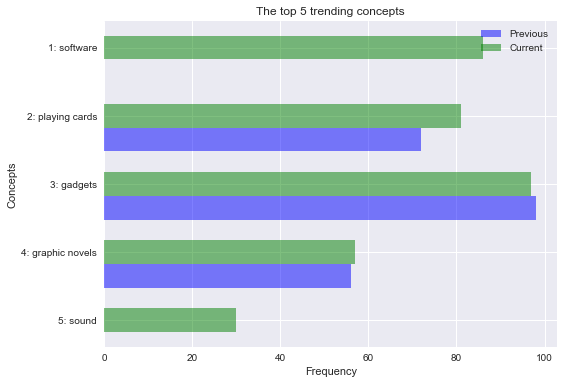

In [19]:
sns.set_style()

start_d, end_d = '2015-05-01', '2015-06-01'
smooth_param = 10
no_tops = 5
df = compare_chi_sq(data, header_list, start_d, end_d, smooth_param, no_tops)

# data to plot
n_groups = no_tops
current = df.count_current.values[::-1]
previous = df.count_previous.values[::-1]

ind_list = []
for n in range(no_tops):
    ind_list.append(str(int(df['rank_current'].iloc[4 - n])) + ': ' + df.index.values[4 - n])
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
 
rects1 = plt.barh(index, previous, bar_width,
                 color='b',
                 label='Previous', alpha=0.5)
 
rects2 = plt.barh(index + bar_width, current, bar_width,
                 color='g',
                 label='Current', alpha=0.5)
 
plt.xlabel('Frequency')
plt.ylabel('Concepts')
plt.title('The top 5 trending concepts')
plt.yticks(index + bar_width, ind_list)
plt.legend(loc='best')
 
plt.tight_layout()
plt.show()

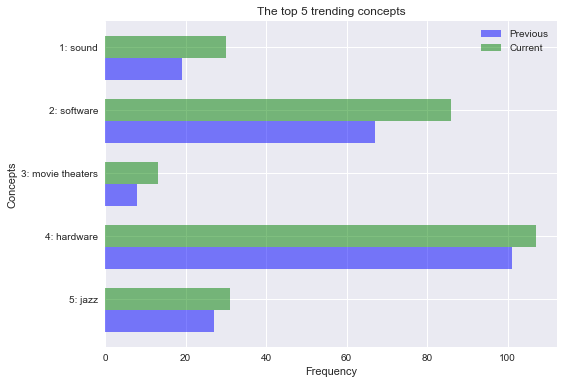

In [20]:
sns.set_style()

start_d, end_d = '2015-05-01', '2015-06-01'
smooth_param = 10
no_tops = 5
df = compare_zscore(data, header_list, start_d, end_d, smooth_param, no_tops)

# data to plot
n_groups = no_tops
current = df.count_current.values[::-1]
previous = df.count_previous.values[::-1]

ind_list = []
for n in range(no_tops):
    ind_list.append(str(int(df['rank_current'].iloc[4 - n])) + ': ' + df.index.values[4 - n])
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
 
rects1 = plt.barh(index, previous, bar_width,
                 color='b',
                 label='Previous', alpha=0.5)
 
rects2 = plt.barh(index + bar_width, current, bar_width,
                 color='g',
                 label='Current', alpha=0.5)
 
plt.xlabel('Frequency')
plt.ylabel('Concepts')
plt.title('The top 5 trending concepts')
plt.yticks(index + bar_width, ind_list)
plt.legend(loc='best')
 
plt.tight_layout()
plt.show()

# The trending functions:

In [21]:
#choice of start and end dates
start_d, end_d = '2015-05-01', '2015-06-01'
#choice of smoothing parameter
smooth_param = 10
#number of top segments to display
no_tops = 5

df = compare_zscore(data, header_list, start_d, end_d, smooth_param, no_tops).loc[:, ['rank_current', 'rank_previous']]
df = df.astype('float')
d = df.to_dict()

# Writing JSON data
with open('data_zscore.json', 'w') as f:
     json.dump(d, f)
        
with open('data_zscore.json', 'r') as f:
     print(json.load(f))

{'rank_current': {'sound': 1.0, 'software': 2.0, 'movie theaters': 3.0, 'hardware': 4.0, 'jazz': 5.0}, 'rank_previous': {'sound': 191.0, 'software': 129.0, 'movie theaters': 41.0, 'hardware': 110.0, 'jazz': 171.0}}


In [22]:
#choice of start and end dates
start_d, end_d = '2015-05-01', '2015-06-01'
#choice of smoothing parameter
smooth_param = 10
#number of top segments to display
no_tops = 5

df = compare_chi_sq(data, header_list, start_d, end_d, smooth_param, no_tops).loc[:, ['rank_current', 'rank_previous']]
df = df.astype('float')
d = df.to_dict()

# Writing JSON data
with open('data_zscore.json', 'w') as f:
     json.dump(d, f)
        
with open('data_zscore.json', 'r') as f:
     print(json.load(f))

N: 3
N: 2
{'rank_current': {'software': 1.0, 'playing cards': 2.0, 'gadgets': 3.0, 'graphic novels': 4.0, 'sound': 5.0}, 'rank_previous': {'software': nan, 'playing cards': 56.0, 'gadgets': 5.0, 'graphic novels': 10.0, 'sound': nan}}


As discussed earlier, if we are not too worried about the speed of the process and we have sufficient data to achieve large $N$, then we probably should use the $\chi^2$ approach. However, if speed is a priority or we have insufficient data to achieve large $N$, then we should probably consider the z-score approach.

However, both models suffer from the limitation that they depend on a smoothing parameter. It would be good to remove this dependence.

# Appendix:

In this appendix, I implement _non-negative matrix factorization_, to cluster campaigns, based on the concepts occurring in all of the 'concepts' keys. We shall see that the results obtained are not optimal, and therefore we only include this as an appendix.

We firstly convert all of the data to a dataframe:

In [23]:
t0 = timer()

max_ = len(data)

header_list = ['title', 'subtitle', 'category', 'description']
date_list = ['start_time', 'end_time']

concept_dict = {k:[] for k in header_list + date_list}
for n in range(max_):
    #generate the start and end date values
    for date in date_list:
        if date in data[n].keys():
            concept_dict[date].append(data[n][date])
    
    #generate the concept values
    if 'concepts' in data[n].keys():
        for header in header_list:
            temp_list = []
            if header in data[n]['concepts'].keys():
                for entry in data[n]['concepts'][header]:
                    temp_list.append(entry['concept'])
                if header == 'title':
                    temp_string = ' '.join(temp_list)
                else:
                    temp_string = ', '.join(temp_list)
                concept_dict[header].append(temp_string)
    else:
        for header in header_list:
            concept_dict[header].append('')
            
#format the dataframe and exclude campaigns without titles
data_df = pd.DataFrame.from_dict(concept_dict, orient='index')
data_df = data_df.transpose()
data_df = data_df[data_df.title != '']
data_df = data_df.set_index('title')

print(timer() - t0)

data_df.head()

30.783707331138952


,subtitle,category,description,start_time,end_time
title,,,,,
cafflano® klassic all-in-one coffee maker STAFF PICK,"world, portable all-in-one coffee Maker, grind...","design, product design","world, portable all-in-one coffee Maker, grind...",2015-01-01,2015-01-17
battle game,video games,"games, video games","battle, hetalia, game, battle, hetalia, fan-ma...",2015-01-01,2015-01-31
carbonclip carbon money clip,"first carbon, money clip, cash, cards, large m...","design, product design","carbonclip, things, functionality, carbonclip,...",2015-01-01,2015-01-31
babygurl chocolates confections,small batch,"food, small batch","business, upgraded kitchen, equipment, using h...",2015-01-01,2015-03-01
videos kid perspective,"film, video","film, video","kids, fun, year, old kid",2015-01-01,2015-01-31


We define a function which filters the dataframe, according to start and end date.

In [24]:
def filtered_data(start_date, end_date):
    
    start_con = data_df.start_time < end_date
    end_con = data_df.end_time >= start_date
    
    return data_df[start_con & end_con]

We combine the items in the subtitle and description columns. These give us more data with which to cluster.

In [25]:
data_df['description_combined'] = data_df.subtitle + data_df.description
data_df = data_df.drop(['subtitle', 'description'], axis=1)
data_df[np.invert(data_df.description_combined.isnull())]

data_df.head()

,category,start_time,end_time,description_combined
title,,,,
cafflano® klassic all-in-one coffee maker STAFF PICK,"design, product design",2015-01-01,2015-01-17,"world, portable all-in-one coffee Maker, grind..."
battle game,"games, video games",2015-01-01,2015-01-31,"video gamesbattle, hetalia, game, battle, heta..."
carbonclip carbon money clip,"design, product design",2015-01-01,2015-01-31,"first carbon, money clip, cash, cards, large m..."
babygurl chocolates confections,"food, small batch",2015-01-01,2015-03-01,"small batchbusiness, upgraded kitchen, equipme..."
videos kid perspective,"film, video",2015-01-01,2015-01-31,"film, videokids, fun, year, old kid"


In [33]:
import sklearn.feature_extraction.text as text
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

#pick the minimum number of occurences for which to count a word
min_ = 2
#define the number of topics
n_comps = 50
#define the start and end dates
start_d, end_d = '2016-02-01', '2016-04-01'

#filter the data
fil_df = filtered_data(start_d, end_d)

#initialize the vectorizer
vectorizer = text.CountVectorizer(min_df=min_)
#fit the vectorizer
X = vectorizer.fit_transform(fil_df.description_combined)

#initialize the nmf model
model = NMF(n_components=n_comps)
#fit it to the vectorized data
nmf = model.fit(X)

#obtain the features
nmf_features = model.transform(X)
features_df = pd.DataFrame(nmf_features, index=fil_df.index)
norm_features = normalize(nmf_features)
sim_df = pd.DataFrame(norm_features, index=features_df.index)

#check the similarities for a sample article
article = sim_df.iloc[0]
similarities = sim_df.dot(article)

print(similarities.nlargest())

title
Bed time story child book                 1.000000
love peanut butter photo book             0.857107
blue mariposa billingual children book    0.721890
fangs kiteboard fins                      0.712049
believers network                         0.697734
dtype: float64


This looks okay, but not particuarly good at clustering the topics.

We define a function which displays the top words in a topic.

In [49]:
def display_topic(model, feature_names, no_top_words, topic_number):
    print("Topic %d:" % (topic_number))
    print(" ".join([feature_names[i]
                        for i in model.components_[topic_number].argsort()[:-no_top_words - 1:-1]]))

We now check the top words in the top topic of the campaign considered above:

In [48]:
ind = sim_df.iloc[0,:][sim_df.iloc[0,:] == max(sim_df.iloc[0,:])].index.values[0]

display_topic(nmf, vectorizer.get_feature_names(), 5, ind)

Topic 5:
book children coloring photo illustrations


It may be seen by looking at the similarities of other campaigns, that this clustering is still not particularly accurate. __Possible extensions__ would be to play around more with the parameters of the clustering model, or to also try LDA clustering, or hash functions.